In [11]:
CLASSES = 2
input_size = 224
BATCH_SIZE = 32
import matplotlib.pyplot as plt
import tensorflow as tf
import os, random
import numpy as np
import cv2 as cv
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, AveragePooling2D

In [12]:
model = tf.keras.models.Sequential( [
    tf.keras.layers.Conv2D(16, kernel_size = 3, activation = 'relu', input_shape = (224,224,1) ),
    tf.keras.layers.AveragePooling2D(2,2),

    tf.keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu'),
    tf.keras.layers.AveragePooling2D(2,2),

    tf.keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu'),
    tf.keras.layers.AveragePooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(CLASSES, activation = 'softmax')
] )

In [13]:
CLASSES = 2
def build_classifier(inputs):
  x = tf.keras.layers.Conv2D(16, kernel_size = 3, activation = 'relu', input_shape=(input_size, input_size, 1)) (inputs)
  x = tf.keras.layers.AveragePooling2D(2,2) (x),

  x = tf.keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu') (x),
  x = tf.keras.layers.AveragePooling2D(2,2) (x),

  x = tf.keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu') (x),
  x = tf.keras.layers.AveragePooling2D(2,2) (x),

  x =  tf.keras.layers.Flatten()(inputs),
  x =  tf.keras.layers.Dense(64, activation = 'relu')(x),
  x =  tf.keras.layers.Dense(CLASSES, activation = 'softmax')(x)

  return x

In [14]:
def build_regressor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    x = tf.keras.layers.Dense(units = '4')(inputs)(x)

    return x

In [15]:
def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

In [16]:
def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

In [17]:
def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = 4 , name = 'regressor_head')(inputs)

In [18]:
def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    return model

In [19]:
def list_files(full_data_path = "/content/drive/MyDrive/Labeled Mask Dataset/obj", image_ext = '.jpg', split_percentage = [70,20]):
  files = []
  discarded = 0
  masked_instance = 0

  for r, d, f in os.walk(full_data_path):
    for file in f:
      if file.endswith(".txt"):
        with open(full_data_path + "/" + file, 'r') as fp:
          lines = fp.readlines()
          if len(lines) > 1:
            discarded += 1
            continue
        strip = file[0:len(file) - len(".txt")]
        image_path = full_data_path + "/" + strip + image_ext
        if os.path.isfile(image_path):
            if lines[0][0] == '0':
              masked_instance += 1
            files.append(os.path.join(r, strip))
  size = len(files)
  print(str(discarded) + " File(s) Discarded")
  print(str(size) + " Valid Case(s)")
  print(str(masked_instance) + " are masked cases")

  random.shuffle(files)
  split_training = int(split_percentage[0] * size / 100)
  split_validation = split_training + int(split_percentage[1] * size / 100)
  return files[0:split_training], files[split_training:split_validation], files[split_validation:]

training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

218 File(s) Discarded
1292 Valid Case(s)
832 are masked cases
904 training files
258 validation files
130 test files


In [20]:
def format_image(img, box):
  height, width = img.shape
  max_size = max(height, width)
  r = max_size / input_size
  new_width = int(width / r)
  new_height = int(height / r)
  new_size = (new_width, new_height)
  resized = cv.resize(img, new_size, interpolation = cv.INTER_LINEAR)
  new_image = np.zeros((input_size, input_size), dtype=np.uint8)
  new_image[0:new_height, 0:new_width] = resized

  x,y,w,h = box[0], box[1],box[2], box[3]
  new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]
  return new_image, new_box

In [21]:
def load_and_process_data(file_prefix, input_size=input_size):
    image_path = file_prefix + '.jpg'
    annotation_path = file_prefix + '.txt'

    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    with open(annotation_path, 'r') as f:
        line = f.readline().strip()
        parts = line.split(' ')
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])

    yolo_box_normalized = [x_center, y_center, width, height]

    processed_image_np, plot_box_pixels_np = format_image(img, yolo_box_normalized)

    formatted_image_tensor = tf.cast(processed_image_np, tf.float32) / 255.0
    formatted_image_tensor = tf.expand_dims(formatted_image_tensor, axis=-1) # (H, W) -> (H, W, 1)

    classification_label = tf.one_hot(class_id, depth=CLASSES)

    x_pixel, y_pixel, w_pixel, h_pixel = plot_box_pixels_np
    x1_norm = x_pixel / input_size
    y1_norm = y_pixel / input_size
    x2_norm = (x_pixel + w_pixel) / input_size
    y2_norm = (y_pixel + h_pixel) / input_size
    regressor_box_tensor = tf.cast([x1_norm, y1_norm, x2_norm, y2_norm], tf.float32)

    return formatted_image_tensor, (classification_label, regressor_box_tensor, tf.cast(plot_box_pixels_np, tf.int32))

In [22]:
def create_dataset(file_paths, batch_size):
    def data_generator():
        for file_prefix in file_paths:
            try:
                # Yields: image, (classification_label, regressor_box_tensor, plot_box_pixels)
                yield load_and_process_data(file_prefix, input_size)
            except FileNotFoundError as e:
                print(f"Skipping file due to error: {e}")
                continue
            except Exception as e:
                print(f"Error processing {file_prefix}: {e}")
                continue

    # Define the output signatures for the generator (CRITICAL for from_generator)
    output_signature = (
        tf.TensorSpec(shape=(input_size, input_size, 1), dtype=tf.float32), # Image
        (
            tf.TensorSpec(shape=(CLASSES,), dtype=tf.float32),  # Classification label (one-hot)
            tf.TensorSpec(shape=(4,), dtype=tf.float32),       # Regressor box (normalized x1, y1, x2, y2)
            tf.TensorSpec(shape=(4,), dtype=tf.int32)         # Plotting box (x, y, w, h in pixels)
        )
    )

    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=output_signature
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE) # Optimizes data loading
    return dataset

In [23]:
train_ds = create_dataset(training_files, BATCH_SIZE)
validation_ds = create_dataset(validation_files, BATCH_SIZE)
test_ds = create_dataset(test_files, BATCH_SIZE)

print("\n--- Datasets Created Successfully ---")
print(f"Train Dataset: {train_ds}")
print(f"Validation Dataset: {validation_ds}")
print(f"Test Dataset: {test_ds}")


--- Datasets Created Successfully ---
Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.int32, name=None)))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.int32, name=None)))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.int32, name=None)))>


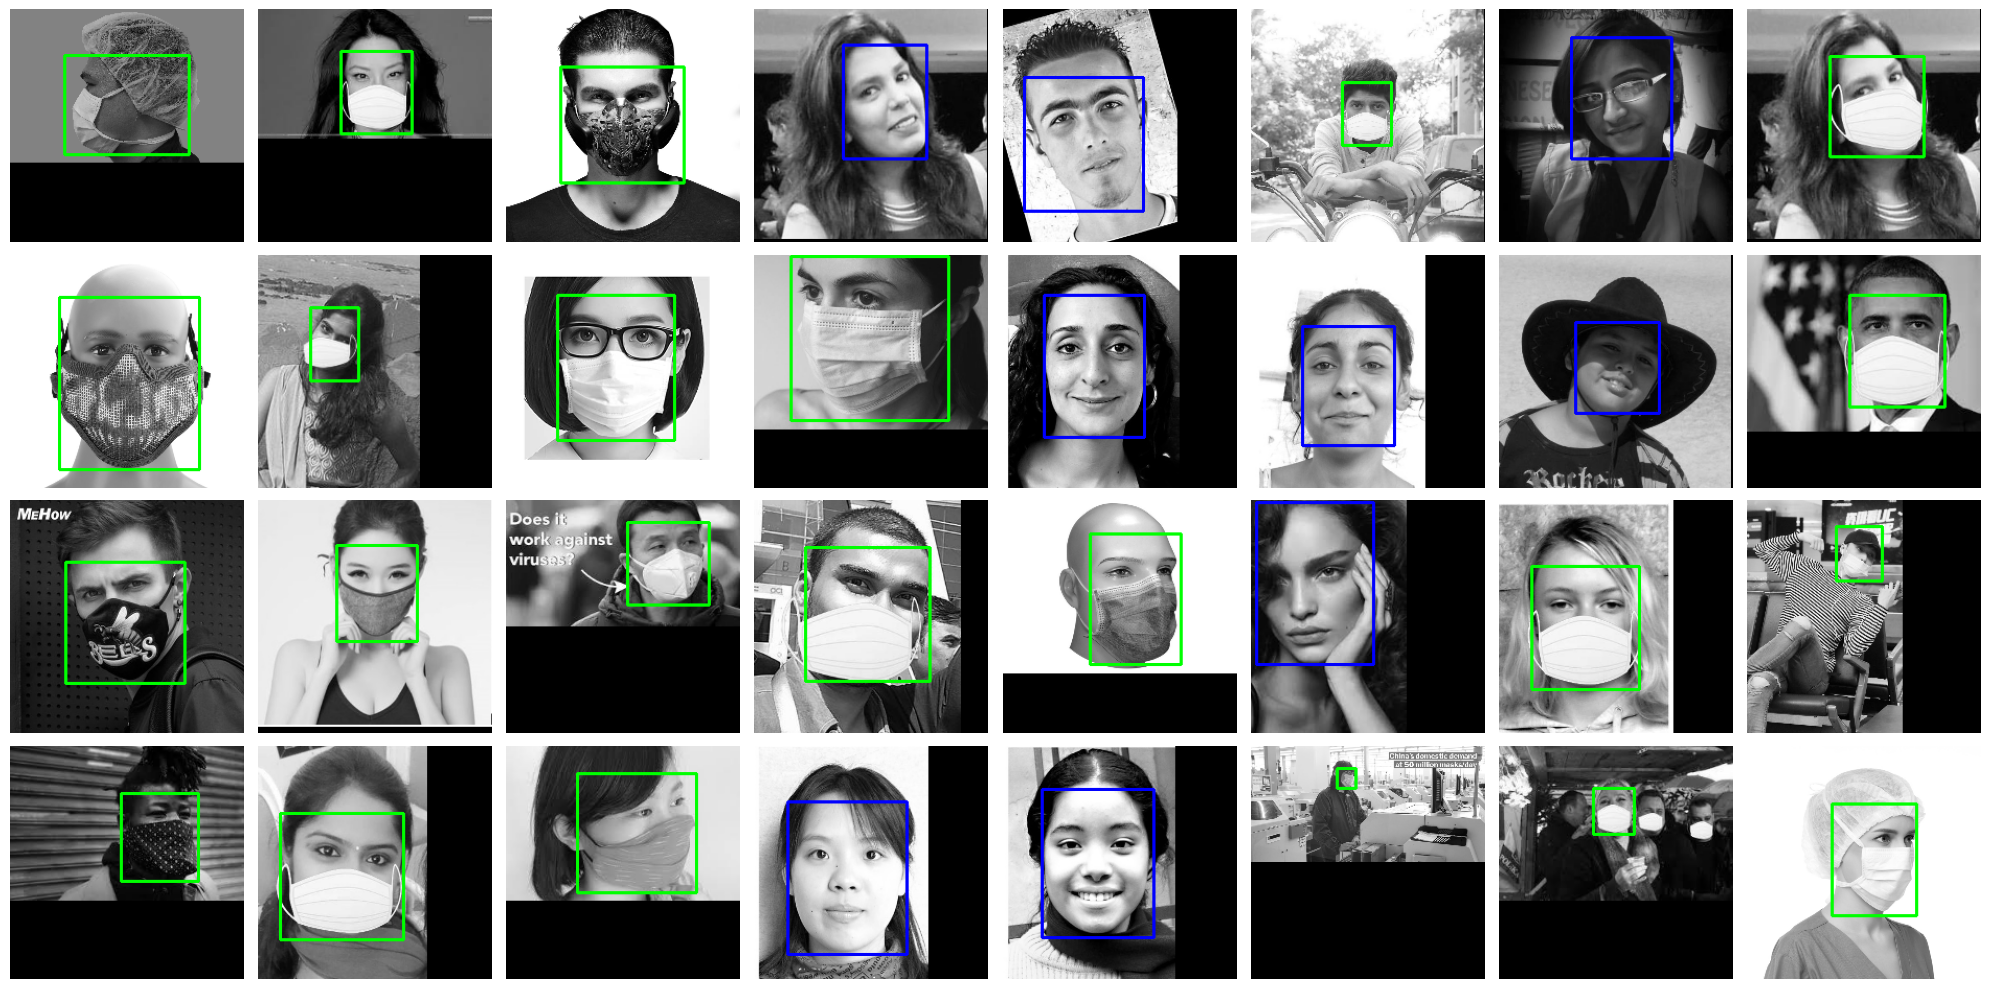

In [24]:

plt.figure(figsize=(20, 10))

for images, labels_tuple in train_ds.take(1):
    classification_labels_batch = labels_tuple[0]
    plot_boxes_pixels_batch = labels_tuple[2]

    for i in range(min(BATCH_SIZE, images.shape[0])):
        ax = plt.subplot(4, BATCH_SIZE // 4, i + 1)

        label = classification_labels_batch[i]
        plot_box = plot_boxes_pixels_batch[i]

        image = images[i].numpy() * 255.0
        image = image.astype(np.uint8).squeeze()

        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if tf.argmax(label) == 0:
            color = (0, 255, 0)

        plot_box_list = plot_box.numpy().tolist()
        cv.rectangle(image_color,
                     (plot_box_list[0], plot_box_list[1]),
                     (plot_box_list[0] + plot_box_list[2], plot_box_list[1] + plot_box_list[3]),
                     color, 2)

        plt.imshow(image_color)
        plt.axis("off")
plt.tight_layout()
plt.show()

In [25]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' },
    metrics={'classifier_head' : 'accuracy', 'regressor_head' : 'mse' }
)

EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(
    train_ds.map(lambda img, labels: (img, (labels[0], labels[1]))), # Only pass img and the first two labels
    steps_per_epoch=(len(training_files) // BATCH_SIZE),
    validation_data=validation_ds.map(lambda img, labels: (img, (labels[0], labels[1]))), # Same for validation
    validation_steps=1,
    epochs=EPOCHS
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - classifier_head_accuracy: 0.6079 - classifier_head_loss: 0.6228 - loss: 0.7168 - regressor_head_loss: 0.0941 - regressor_head_mse: 0.0941 - val_classifier_head_accuracy: 0.7188 - val_classifier_head_loss: 0.5083 - val_loss: 0.5224 - val_regressor_head_loss: 0.0141 - val_regressor_head_mse: 0.0141
Epoch 2/10
 1/28 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - classifier_head_accuracy: 0.5000 - classifier_head_loss: 0.5617 - loss: 0.5725 - regressor_head_loss: 0.0108 - regressor_head_mse: 0.0108

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - classifier_head_accuracy: 0.5000 - classifier_head_loss: 0.2909 - loss: 0.5725 - regressor_head_loss: 0.0056 - regressor_head_mse: 0.0108 - val_classifier_head_accuracy: 0.7500 - val_classifier_head_loss: 0.5138 - val_loss: 0.5283 - val_regressor_head_loss: 0.0146 - val_regressor_head_mse: 0.0146
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - classifier_head_accuracy: 0.7478 - classifier_head_loss: 0.5435 - loss: 0.5596 - regressor_head_loss: 0.0160 - regressor_head_mse: 0.0160 - val_classifier_head_accuracy: 0.7812 - val_classifier_head_loss: 0.4474 - val_loss: 0.4607 - val_regressor_head_loss: 0.0133 - val_regressor_head_mse: 0.0133
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - classifier_head_accuracy: 0.8750 - classifier_head_loss: 0.2438 - loss: 0.4821 - regressor_head_loss: 0.0058 - regressor_head_mse: 0.0113 - val_classifier_head_accuracy: 0.8750 - val_classifier_head_loss: 0.4662 - val_loss: 0.4806 - val_regressor_head_loss:

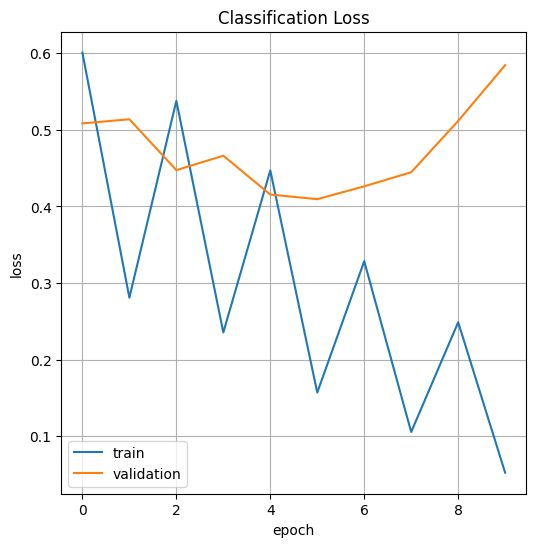

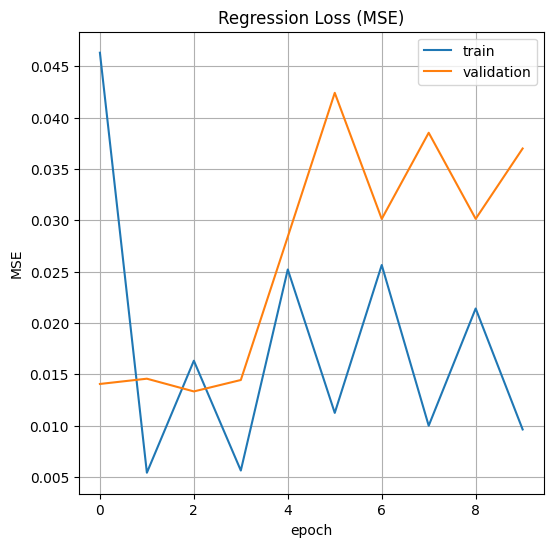

In [26]:

plt.figure(figsize=(6, 6))
plt.plot(history.history['classifier_head_loss'], label='train')
plt.plot(history.history['val_classifier_head_loss'], label='validation')
plt.title('Classification Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(history.history['regressor_head_loss'], label='train')
plt.plot(history.history['val_regressor_head_loss'], label='validation')
plt.title('Regression Loss (MSE)')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

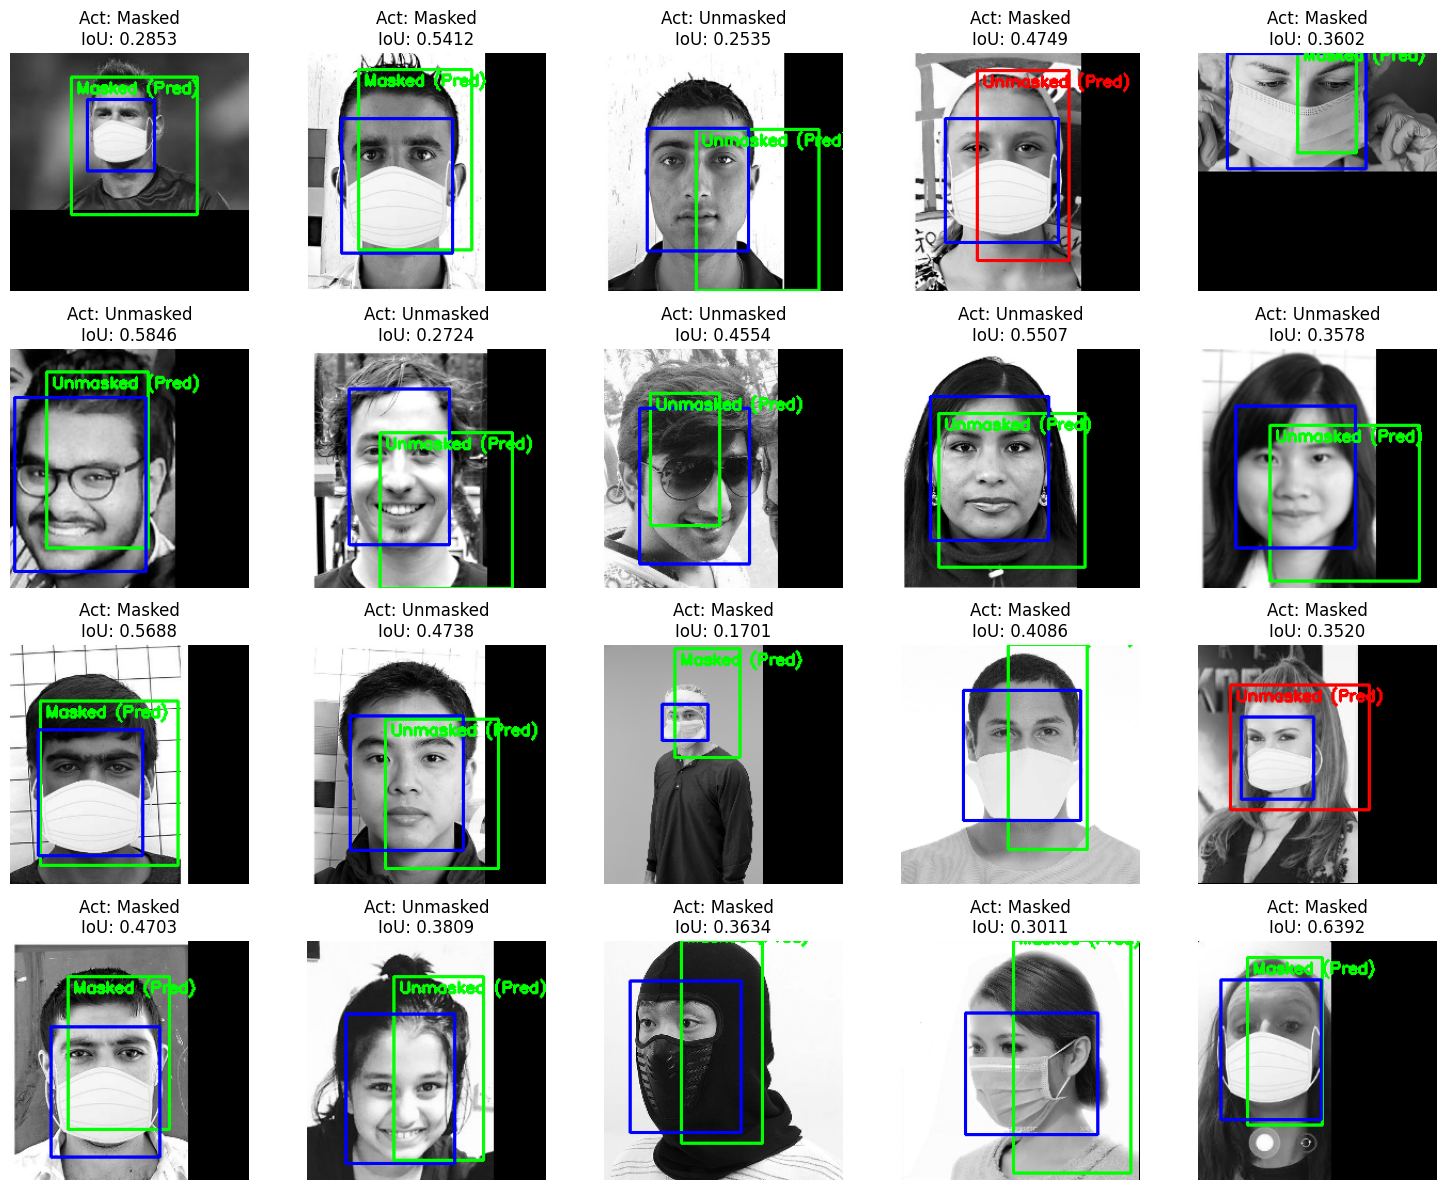

In [28]:
for batch_images, batch_labels_tuple in test_ds.take(1):
    batch_actual_classification_labels = batch_labels_tuple[0]
    batch_actual_regressor_boxes_norm = batch_labels_tuple[1]
    batch_actual_plot_boxes_pixels = batch_labels_tuple[2]


    num_images_to_plot = min(20, batch_images.shape[0])

    plt.figure(figsize=(15, 12))


    for i in range(num_images_to_plot):
        ax = plt.subplot(4, 5, i + 1)


        image = batch_images[i]
        actual_label_one_hot = batch_actual_classification_labels[i]

        actual_plot_box_pixels = batch_actual_plot_boxes_pixels[i]


        predictions = model(tf.expand_dims(image, axis=0))

        predicted_label_probs = predictions[0][0]
        predicted_regressor_box_norm = predictions[1][0]


        x1_pred_pixel = int(predicted_regressor_box_norm[0] * input_size)
        y1_pred_pixel = int(predicted_regressor_box_norm[1] * input_size)
        x2_pred_pixel = int(predicted_regressor_box_norm[2] * input_size)
        y2_pred_pixel = int(predicted_regressor_box_norm[3] * input_size)
        predicted_box_pixels_np = np.array([x1_pred_pixel, y1_pred_pixel,
                                            x2_pred_pixel - x1_pred_pixel,
                                            y2_pred_pixel - y1_pred_pixel], dtype=np.int32)


        display_image = image.numpy().squeeze() * 255.0
        display_image = display_image.astype(np.uint8)
        image_color = cv.cvtColor(display_image, cv.COLOR_GRAY2RGB)


        predicted_class_id = np.argmax(predicted_label_probs)
        actual_class_id = np.argmax(actual_label_one_hot)

        plot_color = (0, 255, 0)
        img_label = "Masked (Pred)" if predicted_class_id == 0 else "Unmasked (Pred)"


        if predicted_class_id != actual_class_id:
             plot_color = (255, 0, 0)



        cv.rectangle(image_color, predicted_box_pixels_np.tolist(), plot_color, 2)
        cv.rectangle(image_color, actual_plot_box_pixels.numpy().tolist(), (0, 0, 255), 2)

        cv.putText(image_color, img_label,
                   (predicted_box_pixels_np[0] + 5, predicted_box_pixels_np[1] + 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, plot_color, 2)

        iou_val = intersection_over_union(predicted_box_pixels_np, actual_plot_box_pixels.numpy())

        plt.title(f"Act: {('Masked' if actual_class_id == 0 else 'Unmasked')}\nIoU: {iou_val:.4f}")
        plt.imshow(image_color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()